# Imports

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
import data_processing
import plots
import models
import experiments

# Generate synthetic data

In [ ]:
orig_data = pd.read_csv("datasets/src/breast_cancer_rna.csv")
df_syn = orig_data

In [ ]:
_, df_syn = data_processing.generate_synthetic_data(orig_data, 2000)

In [ ]:
time, censor = data_processing.determine_censor_time(df_syn)
# we can generate extra data and use only the censored samples from a given point to get a dataset with higher censoring percentage 
df_tmp = df_syn.iloc[20001:40000, :]
df_tmp2 = df_syn.iloc[0:20001, :]
df_tmp2 = pd.concat([df_tmp2, df_tmp.loc[(df_tmp['time'] < time) & (df_tmp['censor'] == False)]])

In [ ]:
df_syn.to_excel('datasets/syn/sksurv_aids.xlsx')

# Experiment
## Load pre-saved data

In [27]:
df_syn = pd.read_excel("datasets/syn/sksurv_gbsg2.xlsx", index_col=0)

In [ ]:
# plot censored percentage by time if we want to manually pick the timeframe, can also use data_processing.determine_censor_time
plots.censored_by_time_plot(df_syn)

In [ ]:
# set censor time manually
censor_time = 230
print(df_syn[(df_syn['time'] < censor_time) & (df_syn['censor'] == False)].shape[0])
df_syn[(df_syn['time'] < censor_time) & (df_syn['censor'] == False)].shape[0]/df_syn.shape[0]

In [ ]:
plots.censored_samples_by_time(df_syn, censor_time, 'aids')

## Hyperparameter tuning

In [31]:
models_dict = {'Forest': (RandomSurvivalForest, RandomForestClassifier), 'Regression': (CoxPHSurvivalAnalysis, LogisticRegression)}
tuning_parmas_dict = {'Forest': {'n_estimators': [50, 80, 100, 200], 'max_depth': [4, 8, 16, 24, 32, None], 'min_samples_split': [2, 4, 8], 'max_features': ['log2', 'sqrt']},
                 'Regression': {}}

exp_model_type = 'Regression'
surv_model, sk_model = models_dict[exp_model_type]
tuning_parmas = tuning_parmas_dict[exp_model_type]

In [29]:
# if we want to use default params
surv_params = None
sklearn_params = None

In [ ]:
df_exp = df_syn
surv_params, best_auc_rsf = models.model_tuning_rsf(df_exp, censor_time, tuning_parmas, 3)

In [ ]:
df_exp = df_syn
datasets = data_processing.create_datasets(df_syn, censor_time)
sklearn_params, best_auc_sklearn = models.model_tuning(datasets['uncensored']['X_train'],datasets['uncensored']['y_train'], sk_model(n_jobs=-1), tuning_parmas, verbose=3)

In [ ]:
print(f"surv model params: {surv_params}")
print(f"sklearn model params: {sklearn_params}")

## Train and score models

In [ ]:
# if we want to manually change params
surv_params = {'n_estimators': 200, 'max_features': 1.0}

In [ ]:
sklearn_params =  {'n_estimators': 100, 'max_features': 1.0}

  0%|          | 0/1 [00:00<?, ?it/s]

uncensored train size: 320, test size: 80
censored train size (0.0% censoring): 320
censored train size (12.0% censoring): 363
censored train size (24.0% censoring): 421
censored train size (36.0% censoring): 499



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

censored train size (48.0% censoring): 615
censored train size (60.0% censoring): 800


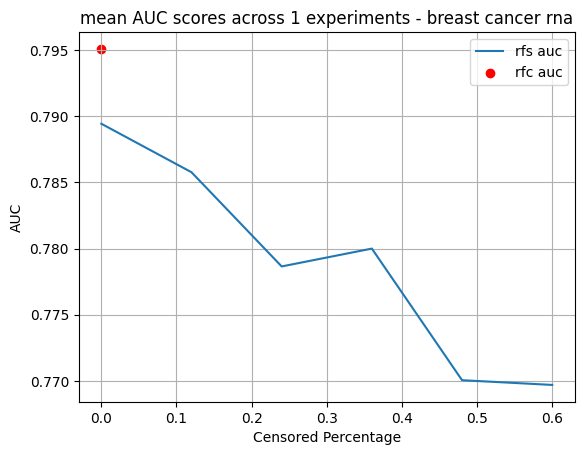

In [33]:
sk_auc_mean = 0
dataset_name = 'breast cancer rna'
percentage = 60
sample_size = 1000
surv_auc_mean = np.zeros(int(percentage/10))
num_experiments = 1
n_sub_dataset = 1
for j in tqdm(range(n_sub_dataset)):
    df_exp = df_syn.sample(sample_size)
    censor_time, percentage = data_processing.determine_censor_time(df_exp, percentage)
    censor_vals = np.linspace(0, percentage, int(percentage/10))/100
    for i in tqdm(range(num_experiments)):
        rfc_auc, rsf_aucs, datasets = experiments.run_experiment(df_exp, censor_vals, censor_time, models_dict[exp_model_type], (surv_params, sklearn_params), test_size_relative=False, debug=True)
        sk_auc_mean += rfc_auc
        surv_auc_mean += np.asarray(rsf_aucs)
sk_auc_mean /= num_experiments*n_sub_dataset
surv_auc_mean /= num_experiments*n_sub_dataset
plots.line_plot(surv_auc_mean, sk_auc_mean, censor_vals, num_experiments, dataset_name)

In [ ]:
plots.line_plot(surv_auc_mean, sk_auc_mean, censor_vals, num_experiments, dataset_name)

In [38]:
experiments.exp_report(sample_size, dataset_name, censor_vals, datasets, censor_time, exp_model_type, surv_params, sklearn_params, {'sk_auc_mean': sk_auc_mean, 'surv_auc_mean': surv_auc_mean})